# The k-Armed Bandit Problem

### 10-armed bandits testbed

Create a set of 2000 randomly generated 10-armed bandit models.
Each row stores the model of one k-armed bandit (a slot machine with k arms), each cell in the row stores the true Expected value of the reward given by each of the k possible actions that the agent (player) can do on the bandit (pull one of the k levers), this true expected value (true mean) is distributed normally with mean 0 and variance 1. 

In [3]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
n = 2000
k = 10
models = np.random.normal(0.0, 1.0, size=(n, k))

models[0:1,:]

array([[ 0.68584993,  0.08536502, -0.54809094,  1.18119147, -0.54296115,
         0.69395547,  0.53901322, -1.51340444, -0.37063819,  0.07828604]])

The actual reward from a bandit is stochastic, the algorithm learns a model of the Expected reward, and the actual reward is random with q∗(At) as mean (expectation) and variance 1.

In [5]:
# the bandit returns the actual reward from the true model
def bandit(row, a):
    r = models[row, a] + np.random.normal()
    return r

## Action-Value Methods
### ε-greedy method - Incremental implementation (Sutton-Barto 2.3)

Greedy action: q∗(At), the action with maximum reward.

In [6]:
# greedy action index
q_opt = np.argmax(models, 1)  # max along columns (max of each row)
print q_opt[0:1], models[0, q_opt[0]]

[3] 1.18119147198


When a greedy method is applied to the 10-armed testbed, the algorithm chooses the action mith maximum expected reward, this action is called the greedy action q∗(At). Note that the actual reward is stochastic, the model only knows the Expected reward, and the actual reward is random with q∗(At) as mean (expectation) and variance 1.

In [7]:
# ε-greedy method (Sutton-Barto 2.2)
def epsilon_greedy(Q, epsilon):
    a =  np.random.choice(range(10)) if np.random.sample() < epsilon else np.argmax(Q)
    return a

The estimator of the action values is the averages of the observed rewards for each action.
To compute these estimators with minimum computational cost, we apply an incremental formula for updating averages with small, constant computation required to process
each new reward.

In [8]:
def update_rule(old_estimate, target, step_size):
    new_estimate = old_estimate + step_size * (target - old_estimate)
    return new_estimate

In [17]:
Qs = np.zeros(shape=(n, k))
num_steps = 1000
epsilon = .1
 
# ratio for plotting performance
ratio_est_vs_opt = np.zeros(shape=(n, num_steps))
# accumulators for plotting performance
rewards_accum =   np.zeros(shape=(n, num_steps))
opt_rewards_accum =   np.zeros(shape=(n, num_steps)) + 1/10**6 # avoid division by zero at step zero
    
# for each model
for i in range(n):
    N = np.zeros(k) # action_counters
    
    # 1 run
    for t in range(num_steps):       
        # estimate best action, based on estimated action-values, with epsilon-greedy method
        a = epsilon_greedy(Qs[i,:], epsilon)
        
        # act and collect the actual reward from the bandit
        reward = bandit(i, a)

        # update our estimate of the action value 
        N[a] += 1
        Qs[i, a] = update_rule(Qs[i, a], reward, 1/N[a])
              
        # store the accumulators to calculate the ratio of epsilon-greedy vs optimal at each step for plotting
        if t > 0:
            rewards_accum[i, t] = rewards_accum[i, t-1] + reward
            opt_rewards_accum[i, t] = opt_rewards_accum[i, t-1] + bandit(i, q_opt[i])

# Compute ratio of cumulative rewards
# The stationary bandit test bed often contains commulative rewards that are close to zero
# I average over the 2000 models before computingthe ratio

# mean along rows (avg of each step over all models)
avg_rewards_accum = np.mean(rewards_accum, 0)
avg_opt_rewards_accum = np.mean(opt_rewards_accum, 0)

#  average performance over all models
avg_ratio_est_vs_opt = avg_rewards_accum / avg_opt_rewards_accum

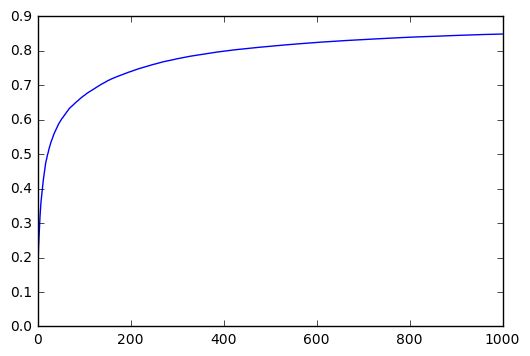

In [18]:
plt.plot(avg_ratio_est_vs_opt)